# Paths and imports handling

In [18]:
import sys
sys.path.insert(0, "..")

from src.path_handling import resolve_path

# Import necessary libraries

In [19]:
# Import necessary libraries
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.chemdata.fingerprints import convert_smiles_to_fingerprints, FINGERPRINT_CLASSES
from src.chemdata import splits
from src.models.metrics import parity_plot

# Load data

In [20]:
# Load data
data_path = resolve_path("./data/logP_dataset.csv")
data = pd.read_csv(data_path, names=["smiles", "logp"])
print(f"Loaded {len(data)} compounds")
print(data)

Loaded 14610 compounds
                                            smiles  logp
0                            C[C@H]([C@@H](C)Cl)Cl   2.3
1                                        C(C=CBr)N   0.3
2                                        CCC(CO)Br   1.3
3      [13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O   2.0
4                                          CCCOCCP   0.6
...                                            ...   ...
14605                                    CCC(SC)Br   2.7
14606                    [2H]C([2H])([C@@H](CO)O)O  -1.8
14607                                     CC(C)NNC   0.4
14608                              C[C@H]1CCC[CH]1   3.4
14609                                   [CH]OC(F)F   1.0

[14610 rows x 2 columns]


# Pre-split analysis of dataset

In [21]:
# Display basic info
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14610 entries, 0 to 14609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  14610 non-null  object 
 1   logp    14610 non-null  float64
dtypes: float64(1), object(1)
memory usage: 228.4+ KB
None


In [8]:
from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles

def smiles_from_mol_from_smiles(smiles: str) -> str:
    """Convert SMILES to molecule and back to SMILES to normalize."""
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(mol)


def count_atoms_from_smiles(smiles: str) -> int:
    """Count number of atoms in a molecule from SMILES."""
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumAtoms()

In [9]:
# Check for duplicates
number_of_duplicates = data["smiles"].apply(smiles_from_mol_from_smiles).duplicated().sum()
print(f"Number of SMILES duplicates in dataset: {number_of_duplicates}")

# Number of atoms distribution
numbers_of_atoms = data["smiles"].apply(count_atoms_from_smiles).values

print("\nnumber of atoms")
print(f"mean:\t{numbers_of_atoms.mean():.1f}")
print(f"std:\t{numbers_of_atoms.std():.1f}")
print(f"min:\t{numbers_of_atoms.min():.1f}")
print(f"max:\t{numbers_of_atoms.max():.1f}")

# Murcko Scaffolds
n_empty_scaffolds = (data['smiles'].apply(MurckoScaffoldSmilesFromSmiles) == '').sum()

print(f"\nN of empty scaffolds:\t{n_empty_scaffolds}")
print(f"% of empty scaffolds:\t{n_empty_scaffolds/len(data)*100:.2f} %")

Number of SMILES duplicates in dataset: 0

number of atoms
mean:	6.3
std:	1.8
min:	2.0
max:	32.0

N of empty scaffolds:	13284
% of empty scaffolds:	90.92 %


# Compare logp from dataset with rdkit crippen

In [10]:
from rdkit.Chem.Crippen import MolLogP

def get_rdkit_logp(smi):
    mol = Chem.MolFromSmiles(smi)
    rdkit_logp = MolLogP(mol)
    return rdkit_logp

y_data = data["logp"].values
y_rdkit = data["smiles"].apply(get_rdkit_logp).values

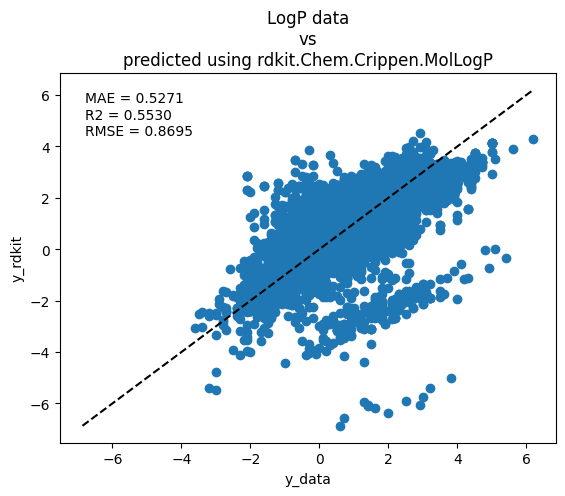

MAE = 0.5271
R2 = 0.5530
RMSE = 0.8695



In [11]:
parity_plot(
    y_1=y_data,
    y_2=y_rdkit,
    title="LogP data\nvs\npredicted using rdkit.Chem.Crippen.MolLogP",
    xlabel="y_data",
    ylabel="y_rdkit"
)

# Replace logp in dataset with rdkit predictions

As we can see in previous python cell, there is strong inconsistency between logp data from dataset and rdkit.Chem.Crippen.MolLogP predictions.

Since this project is just educational, we will use simple method for validation of predicts on new generated molecules. 

So we will replace logp from dataset with logp predicted using rdkit.Chem.Crippen.MolLogP 

In [12]:
data["logp"] = y_rdkit

# Make/save or load random split

In [13]:
# make random split info file if it doesnt exist
split_file = resolve_path("./data/random_split_info.json")

if not split_file.exists():

    train_ids, val_ids, test_ids = splits.create_random_splits(data_length=len(data), random_state=42)

    splits.save_split_info(
        train_ids=train_ids,
        val_ids=val_ids,
        test_ids=test_ids,
        split_file = split_file,
    )

# Load splits and plot target distributions

split_info = splits.load_split_info(split_file)
print(f"Train: {len(split_info['train'])}, Val: {len(split_info['val'])}, Test: {len(split_info['test'])}")


Train: 11688, Val: 1461, Test: 1461


# Plot target distributions for every split

In [14]:
def plot_target_distributions(target: pd.Series, **ids: np.ndarray) -> None:
    """
    Plot violin plots of target distribution across different subsets.
    
    Args:
        target: Target values series
        **ids: Keyword arguments mapping subset names to indices
    """
    plt.figure()
    data_vals = []
    labels = []
    for name, idx in ids.items():
        data_vals.append(target.iloc[idx].values)
        labels.append(name)

    plt.violinplot(data_vals, showmedians=True)
    plt.xticks(range(1, len(ids) + 1), labels=labels)
    plt.tight_layout()
    plt.title(f"target distribution in {', '.join(ids.keys())} subsets")
    plt.show()

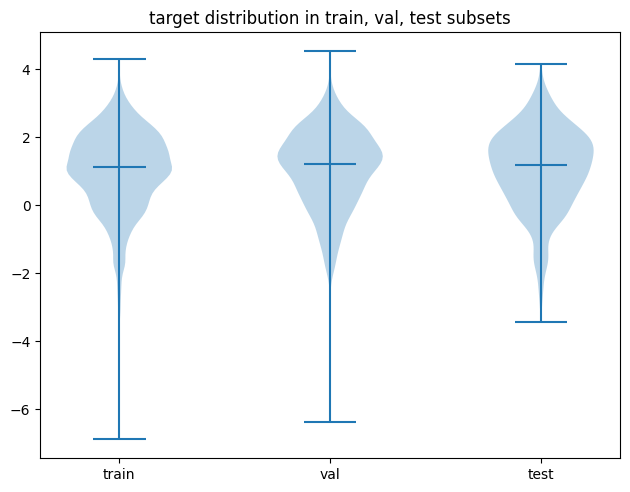

In [15]:
plot_target_distributions(
    target=data["logp"],
    train=split_info["train"],
    val=split_info["val"],
    test=split_info["test"]
)

# Convert train data to fingerprints (subsample for speed)

In [16]:
# Convert to fingerprints (subset for speed)
n_samples = min(1000, len(data))
sample_data = data.iloc[split_info["train"]].sample(n=n_samples, random_state=42)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_data_train = convert_smiles_to_fingerprints(
        smiles=sample_data["smiles"].tolist(),
        fingerprint_classes=FINGERPRINT_CLASSES
    )


[1/7] MorganFingerprint_2048
converting data to MorganFingerprint...


100%|██████████| 1000/1000 [00:00<00:00, 1150.49it/s]


[2/7] FeaturesMorganFingerprint_2048
converting data to FeaturesMorganFingerprint...


100%|██████████| 1000/1000 [00:01<00:00, 922.43it/s]


[3/7] MACCSKeysFingerprint_167
converting data to MACCSKeysFingerprint...


100%|██████████| 1000/1000 [00:00<00:00, 4502.58it/s]


[4/7] RDKitFingerprint_2048
converting data to RDKitFingerprint...


100%|██████████| 1000/1000 [00:01<00:00, 947.08it/s]


[5/7] AtomPairFingerprint_2048
converting data to AtomPairFingerprint...


100%|██████████| 1000/1000 [00:00<00:00, 1037.04it/s]


[6/7] TopologicalTorsionFingerprint_2048
converting data to TopologicalTorsionFingerprint...


100%|██████████| 1000/1000 [00:00<00:00, 4416.68it/s]


[7/7] AvalonFingerprint_1024
converting data to AvalonFingerprint...


100%|██████████| 1000/1000 [00:00<00:00, 1496.73it/s]


In [17]:
# Analyze fingerprint properties
fp_stats = {}
for fp_name, fp_array in X_data_train.items():
    fp_stats[fp_name] = {
        "shape": fp_array.shape,
        "sparsity": 1 - (fp_array.sum() / fp_array.size),
        "mean_bits": fp_array.mean(axis=0).mean(),
        "std_bits": fp_array.std(axis=0).mean()
    }

print("Fingerprint Statistics on train:\n")
for name, stats in sorted(fp_stats.items(), 
                          key=lambda x: x[1]["sparsity"]): # sorted by sparsity
    print(
        f"{name}:\n"
        f"shape: {stats['shape']}\t" 
        f"Mean_bits: {stats["mean_bits"]:4f},\t"
        f"Std_bits: {stats["std_bits"]:.4f}\t"
        f"Sparsity: {stats['sparsity']:.4f},\n"
    )

Fingerprint Statistics on train:

MACCSKeysFingerprint_167:
shape: (1000, 167)	Mean_bits: 0.096108,	Std_bits: 0.2082	Sparsity: 0.9039,

AvalonFingerprint_1024:
shape: (1000, 1024)	Mean_bits: 0.028112,	Std_bits: 0.1187	Sparsity: 0.9719,

RDKitFingerprint_2048:
shape: (1000, 2048)	Mean_bits: 0.016919,	Std_bits: 0.1056	Sparsity: 0.9831,

AtomPairFingerprint_2048:
shape: (1000, 2048)	Mean_bits: 0.007936,	Std_bits: 0.0443	Sparsity: 0.9921,

MorganFingerprint_2048:
shape: (1000, 2048)	Mean_bits: 0.005985,	Std_bits: 0.0524	Sparsity: 0.9940,

FeaturesMorganFingerprint_2048:
shape: (1000, 2048)	Mean_bits: 0.004787,	Std_bits: 0.0286	Sparsity: 0.9952,

TopologicalTorsionFingerprint_2048:
shape: (1000, 2048)	Mean_bits: 0.001577,	Std_bits: 0.0210	Sparsity: 0.9984,



# Conclusion

This datataset does not have duplicates or missing values.

LogP from this dataset dramatically differs from rdkit.Chem.Crippen.MolLogP predictions from the same SMILES strings.
So we decided to replace original data with these predictions.   

This dataset is represented by relatively small molecules (mean number of atoms is ~6) and most of the molecules (~90%) yield murcko scaffold with empty SMILES string. This fact makes it impossible to split data using scaffold split. Alternative to scaffold split is butina split (or any split based on clustering by tanimoto similarity of fingerprints), but it is not guaranteed to work on small molecules such in that dataset. Of course, we can find fingerprint which provides more reasonable clustering, but that means indirect data leakage since we doing it on the whole data including test subset. 

So, **random splitting** would be used for this data. 

Fortunately, target distributions in subsets after random split seem to be generally similar. They're close to normal but have assymetric "tails".

Also, as we can see after random splitting of data, Morgan fingerprint (which is considered as the standard choice for butina split) is very sparse which means it probably wouldn't have provided reasonable clusterisation.